# **5.1: Generating Barabási-Albert Networks**

## **Initializing the algorithm**

In [1]:
using Statistics, Distributions, Plots, StatsBase, StatsPlots, ProgressMeter, LsqFit, LaTeXStrings

println("Packages loaded.\n")

mutable struct Network
    Nodes::Vector{Int} # List of nodes
    Neighbors::Vector{Vector{Int}} # List of edges
    m::Int
    t::Int
end

# function GetNeighbors(network::Network, n::Int)
#     return [first.(network.Eadges[findall(x -> x[2] == n, network.Eadges)])...,
#         last.(network.Eadges[findall(x -> x[1] == n, network.Eadges)])...]
# end

function GetInitNetwork(m::Int)
    # Udirected complete graph with m nodes
    nodes = collect(1:m)
    neighbors = [[j for j ∈ nodes if j != i] for i ∈ nodes]
    return Network(nodes, neighbors, m, 0)
end

function BANextStep!(TheNetwork::Network) # Barabasi-Albert Model step
    Samples = sample(TheNetwork.Nodes, Weights(length.(TheNetwork.Neighbors) / sum(length.(TheNetwork.Neighbors))), TheNetwork.m, replace=true)
    push!(TheNetwork.Nodes, TheNetwork.Nodes[end] + 1)
    push!(TheNetwork.Neighbors, Samples)
    push!.(TheNetwork.Neighbors[Samples], TheNetwork.Nodes[end])
    TheNetwork.t += 1
    return TheNetwork
end

function GetClusteringCoefficient(TheNetwork::Network, n::Int)
    Neighbors = TheNetwork.Neighbors[n]
    if length(Neighbors) < 2
        return 0
    end
    Triangles = 0
    for i ∈ 1:length(Neighbors)
        for j ∈ (i+1):length(Neighbors)
            if Neighbors[j] ∈ TheNetwork.Neighbors[Neighbors[i]]
                Triangles += 1
            end
        end
    end
    return Triangles / (length(Neighbors) * (length(Neighbors) - 1) / 2)
end

println("Functions defined.")

Packages loaded.

Functions defined.


## **Exporting the required data**

In [548]:
TheNetwork = GetInitNetwork(4)
DegreeVault = Vector[]
AvgClusterCoeffs = Float64[]
t100degrees = Vector{Int}[]
t1000degrees = Vector{Int}[]
t5000degrees = Vector{Int}[]
@showprogress for i ∈ 1:10000
    TheNetwork = BANextStep!(TheNetwork)
    if i % 100 == 0
        push!(DegreeVault, length.(TheNetwork.Neighbors))
        push!(AvgClusterCoeffs, mean([GetClusteringCoefficient(TheNetwork, i) for i ∈ TheNetwork.Nodes]))
    end
    if TheNetwork.t >= 100 && i % 10 == 0
        push!(t100degrees, [i, length(TheNetwork.Neighbors[104])])
    end
    if TheNetwork.t >= 1000 && i % 10 == 0
        push!(t1000degrees, [i, length(TheNetwork.Neighbors[1004])])
    end
    if TheNetwork.t >= 5000 && i % 10 == 0
        push!(t5000degrees, [i, length(TheNetwork.Neighbors[5004])])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


## **Fitting the power law**

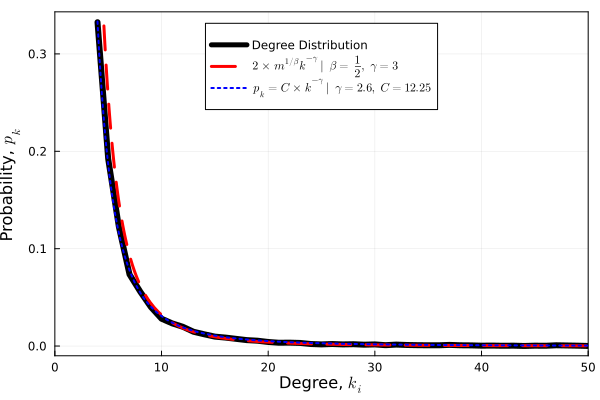

In [549]:
xdata = collect(4.0:maximum(DegreeVault[end]))
Degree_Dist = [count(isequal(k), DegreeVault[end]) for k ∈ xdata]
ydata = Degree_Dist / sum(Degree_Dist)
p0 = [10.0, 3.0]
@. pₖ(k, p) = p[1] * (k^(-p[2]))
DistFit = LsqFit.curve_fit(pₖ, xdata, ydata, p0)
PDF_Coefs = round.(coef(DistFit), digits=2)

plot(xdata[1:100], ydata[1:100], label="Degree Distribution", c=:black, lw=6, legend=:top,
    xlabel="Degree, " * L"k_i", ylabel="Probability, " * L"p_k", frame=:box)
plot!(k -> (2 * TheNetwork.m^(2)) * (k^(-3)), 4.6, xdata[100],
    label=L"2\times m^{1/\beta}k^{-\gamma}\ |\ \beta = \frac{1}{2},\ \gamma = 3",
    c=:red, ls=:dash, lw=3, xlim=(0, 50))
plot!(k -> pₖ(k, PDF_Coefs), xdata[1], xdata[100],
    label=L"p_k = C\times k^{-\gamma}\ |\ \gamma = %$(PDF_Coefs[2]),\ C = %$(PDF_Coefs[1])",
    c=:blue, ls=:dot, lw=2)

## **PDF and CDF of degrees over time**

[ Info: Saved animation to c:\Users\shahm\OneDrive\Desktop\Desktop\Code\Network-Science\ProbSet6\tmp.gif


Plots.AnimatedGif("c:\\Users\\shahm\\OneDrive\\Desktop\\Desktop\\Code\\Network-Science\\ProbSet6\\tmp.gif")
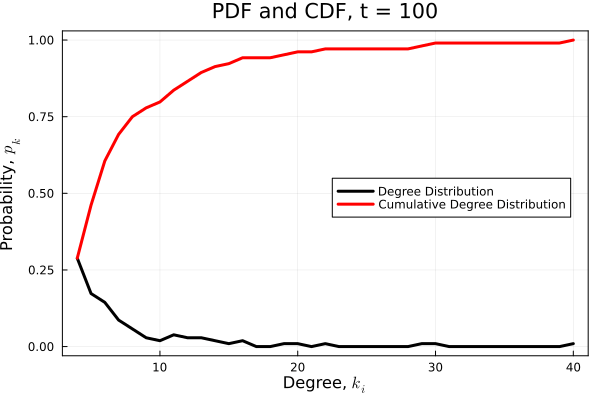

In [550]:
@gif for (i, Degree) ∈ enumerate(DegreeVault)
    kᵢs = collect(4.0:maximum(Degree))
    Degree_Dist = [count(isequal(k), Degree) for k ∈ kᵢs]
    Degree_Density_Dist = Degree_Dist / sum(Degree_Dist)
    Cum_Degree_Dist = [count(x -> x <= k, Degree) for k ∈ kᵢs]
    Cum_Density_Dist = Cum_Degree_Dist / maximum(Cum_Degree_Dist)
    plot(kᵢs, Degree_Density_Dist, label="Degree Distribution", c=:black, lw=3, legend=:right,
        xlabel="Degree, " * L"k_i", ylabel="Probability, " * L"p_k", frame=:box)
    plot!(kᵢs, Cum_Density_Dist, label="Cumulative Degree Distribution", c=:red, lw=3, title="PDF and CDF, t = $(i * 100)")
end

## **Degree distribution over time (Histogram)**

[ Info: Saved animation to c:\Users\shahm\OneDrive\Desktop\Desktop\Code\Network-Science\ProbSet6\tmp.gif


Plots.AnimatedGif("c:\\Users\\shahm\\OneDrive\\Desktop\\Desktop\\Code\\Network-Science\\ProbSet6\\tmp.gif")
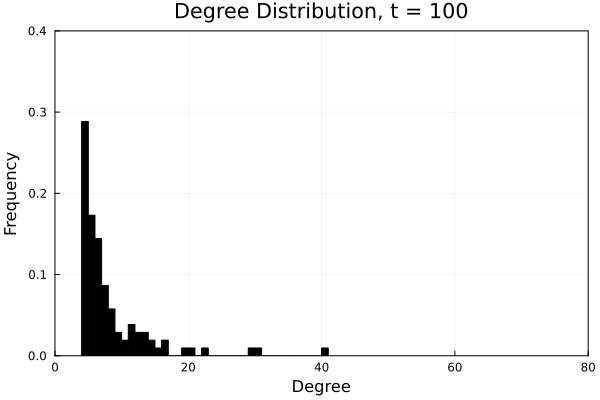

In [551]:
@gif for (i, Degrees) ∈ enumerate(DegreeVault)
    histogram(Degrees, bins=maximum(Degrees), ylim=(0, 0.4), xlim=(0, 80),
        normalize=:probability, label=nothing, xlabel="Degree", ylabel="Frequency",
        title="Degree Distribution, t = $(i * 100)", c = :black, frame=:box)
end

## **Average cluster coefficient over time, ($\langle C \rangle$ function of N)**

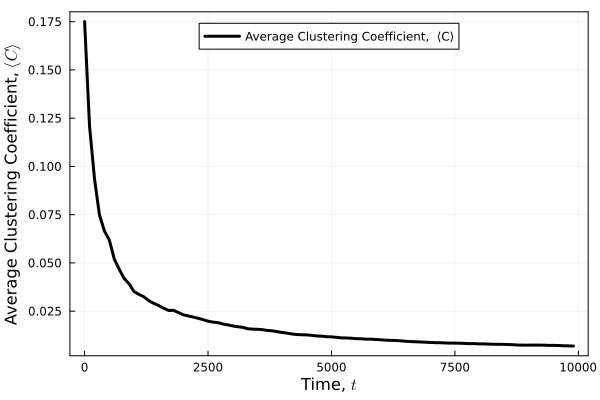

In [552]:
plot(1:100:10000, AvgClusterCoeffs, label="Average Clustering Coefficient,  ⟨C⟩", c=:black, lw=3, legend=:top,
    xlabel="Time, " * L"t", ylabel="Average Clustering Coefficient, " * L"\langle C \rangle", frame=:box)

## **Degree Dynamics**

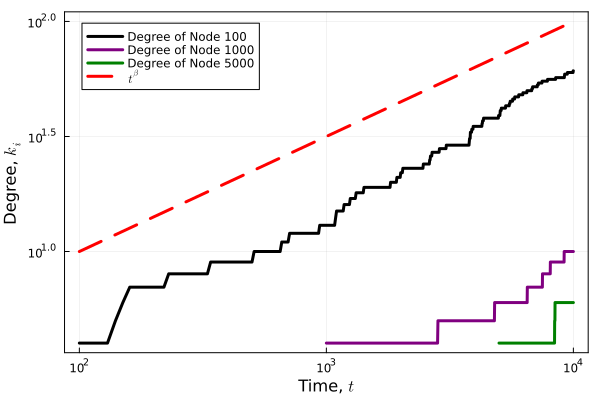

In [561]:
plot(first.(t100degrees), last.(t100degrees), label="Degree of Node 100", c=:black, lw=3, legend=:topleft,
    xlabel="Time, " * L"t", ylabel="Degree, " * L"k_i", frame=:box)
plot!(first.(t1000degrees), last.(t1000degrees), label="Degree of Node 1000", c=:purple, lw=3)
plot!(first.(t5000degrees), last.(t5000degrees), label="Degree of Node 5000", c=:green, lw=3)
plot!(t-> t^(1/2), 100, 10000, label=L"t^{\beta}", c=:red, ls=:dash, lw=3)
plot!(xscale=:log10, yscale=:log10)

# **5.2: Directed Barabási-Albert Model Analysis**


### Out-Degree Distribution ($p_{\text{out}}(k)$):

The out-degree distribution is straightforward since every new node enters the network with $m$ outgoing links:

$$
p_{\text{out}}(k) = \delta(k_{\text{out}} - m) \tag{1}
$$

### Attachment Probability ($\Pi(k)$):

The attachment probability, denoted as $\Pi(k_i)$, is the probability that an existing node with in-degree $k_i$ receives a new link. It is expressed as:

$$
\Pi(k_i) = \frac{k_i + A}{\sum_j (k_j + A)} \tag{2}
$$

Here, $A$ is a constant offset added to every node's in-degree, modifying the preferential attachment.

### Rate Equation for In-Degree Distribution:

The evolution of the in-degree distribution $p_k$ over time can be described using the rate equation approach. Letting $t = N$ represent the current time, the probability distribution after adding one more node ($t = N+1$) is given by:

$$
(N+1)p_k(N+1) = Np_k(N) + \text{number that gained $k$ incoming edges} - \text{number that gained $k+1$ incoming edges} \tag{3}
$$

This leads to a recursive relation:

$$
(N+1)p_k(N+1) = Np_k(N) + \frac{m(k-1+A)}{m+A}p_{k-1}(N) - \frac{m(k+A)}{m+A}p_k(N) \tag{4}
$$

### Stationary Solution:

In the limit as $N \to \infty$, the distribution becomes stationary. For nodes with in-degree $m$ ($k = m$), the equation simplifies:

$$
(N+1)p_m(N+1) = (N-m)p_m(N) + 1 \tag{6}
$$

This yields the stationary solution:

$$
p_m = \frac{1}{m+1} \tag{7}
$$

The general rate equation for other in-degrees is:

$$
(N+1)p_k = Np_k + \frac{m(k-1+A)}{m+A}p_{k-1} - \frac{m(k+A)}{m+A}p_k \tag{8}
$$

### Solving the Rate Equation:

To solve the recursive relation, express it in terms of the beta function:

$$
B(z_1,z_2) = \frac{\Gamma(z_1)\Gamma(z_2)}{\Gamma(z_1+z_2)} \tag{9}
$$

where $\Gamma(z+1) = z\Gamma(z)$. The solution is:

$$
p_k = \frac{B(k+A,2+A/m)}{(m+1)B(m+A,2+A/m)} \tag{11}
$$

### In-Degree Distribution ($p_{\text{in}}(k)$):

For large $k$, the in-degree distribution exhibits a power-law scaling:

$$
p_k \sim k^{-(2+A/m)} \tag{12}
$$

Notably, when $A = 0$, the in-degree distribution is different from the undirected model:

$$
p_k(A=0) = \frac{m}{k(k+1)} \tag{13}
$$

This discrepancy arises because the analysis focuses solely on incoming degrees in this directed model.